# Kohl Reddy Goalie Stats Predictive Analysis

This is a predictive analysis for gsax (goals saved above expected) for goalies in the 2024-25 season based on regular season stats from the current year. The predictions given by the model will be multiplied by the number of games a goalie is projected to play next season in order to predict their aggregate gsax for the year. 

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
sns.set()

In [2]:
##model imports for testing
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

In [3]:
filepath = "C:/Users/kohlr/OneDrive/Documents/Math-250-DESKTOP-S8HNIIO/reddy_final_project/goalies.csv"
df = pd.read_csv(filepath)
df.columns

Index(['playerId', 'season', 'name', 'team', 'position', 'situation',
       'games_played', 'icetime', 'xGoals', 'goals', 'unblocked_shot_attempts',
       'xRebounds', 'rebounds', 'xFreeze', 'freeze', 'xOnGoal', 'ongoal',
       'xPlayStopped', 'playStopped', 'xPlayContinuedInZone',
       'playContinuedInZone', 'xPlayContinuedOutsideZone',
       'playContinuedOutsideZone', 'flurryAdjustedxGoals', 'lowDangerShots',
       'mediumDangerShots', 'highDangerShots', 'lowDangerxGoals',
       'mediumDangerxGoals', 'highDangerxGoals', 'lowDangerGoals',
       'mediumDangerGoals', 'highDangerGoals', 'blocked_shot_attempts',
       'penalityMinutes', 'penalties'],
      dtype='object')

This dataset contains NHL goalie statistics for the regular season for the 2023-24 season. I will use data such as icetime, high, medium and low-danger shots to predict goals saved above expected, a key stat to determine the value that an NHL goaltender adds to his team. Because the data for calculating goals saved above expected is already included in the dataset, I will use only 'save-related' data, or data that ignores any kind of goals allowed by that particular goalie. 

In [4]:
columns_to_drop = ['playerId', 'season', 'position', 'unblocked_shot_attempts' 'xRebounds', 'xFreeze','xPlayStopped', 'xPlayContinuedInZone',
                   'xPlayContinuedOutsideZone', 'flurryAdjustedxGoals', 'blocked_shot_attempts', 'penalityMinutes', 'penalties']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
df.head()

,name,team,situation,games_played,icetime,xGoals,goals,unblocked_shot_attempts,xRebounds,rebounds,...,playContinuedOutsideZone,lowDangerShots,mediumDangerShots,highDangerShots,lowDangerxGoals,mediumDangerxGoals,highDangerxGoals,lowDangerGoals,mediumDangerGoals,highDangerGoals
0,Igor Shesterkin,NYR,other,55,5250.0,8.43,5.0,129.0,5.32,9.0,...,32.0,60.0,16.0,14.0,2.51,1.87,4.05,3.0,1.0,1.0
1,Igor Shesterkin,NYR,all,55,196626.0,153.08,141.0,3231.0,113.42,191.0,...,898.0,1746.0,395.0,169.0,48.54,49.42,55.12,52.0,52.0,37.0
2,Igor Shesterkin,NYR,5on5,55,161016.0,109.50,106.0,2636.0,87.41,149.0,...,734.0,1446.0,315.0,108.0,38.83,40.25,30.43,46.0,40.0,20.0
3,Igor Shesterkin,NYR,4on5,55,15162.0,31.02,26.0,382.0,18.02,31.0,...,82.0,183.0,54.0,43.0,5.41,6.21,19.39,1.0,9.0,16.0
4,Igor Shesterkin,NYR,5on4,55,15198.0,2.17,3.0,60.0,1.69,0.0,...,40.0,42.0,7.0,2.0,0.98,0.78,0.41,1.0,2.0,0.0


In [5]:
df['icetime'] = df['icetime'] / 60
df.shape

(490, 25)

In [6]:
df_full = df.loc[df['icetime'] > 60]



In [7]:
df_full['gsax'] = df_full['xGoals'] - df_full['goals']
df_full['gsax_game'] = df_full['gsax'] / df_full['games_played']
for i in ['low', 'medium', 'high']:
    df_full[f'{i}DangerPct'] = 1 - (df_full[f'{i}DangerGoals'] / df_full[f'{i}DangerShots'])
df_full['shots_Game'] = df_full['ongoal'] / df_full['games_played']
df_full['freeze_Shot'] = df_full['freeze'] / df_full['ongoal']
df_full['rebound_Shot'] = df_full['rebounds'] / df_full['ongoal']
df_full['playStopped_Shot'] = df_full['playStopped'] / df_full['ongoal']
df_full['playContinuedInZone_Shot'] = df_full['playContinuedInZone'] / df_full['ongoal']
df_full['gsax_game'].head()

C:\Users\kohlr\AppData\Local\Temp\ipykernel_24036\858769874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['gsax'] = df_full['xGoals'] - df_full['goals']
C:\Users\kohlr\AppData\Local\Temp\ipykernel_24036\858769874.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_full['gsax_game'] = df_full['gsax'] / df_full['games_played']
C:\Users\kohlr\AppData\Local\Temp\ipykernel_24036\858769874.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

0    0.062364
1    0.219636
2    0.063636
3    0.091273
4   -0.015091
Name: gsax_game, dtype: float64

In [8]:
df_full.isnull().sum()

name                        0
team                        0
situation                   0
games_played                0
icetime                     0
xGoals                      0
goals                       0
unblocked_shot_attempts     0
xRebounds                   0
rebounds                    0
freeze                      0
xOnGoal                     0
ongoal                      0
playStopped                 0
playContinuedInZone         0
playContinuedOutsideZone    0
lowDangerShots              0
mediumDangerShots           0
highDangerShots             0
lowDangerxGoals             0
mediumDangerxGoals          0
highDangerxGoals            0
lowDangerGoals              0
mediumDangerGoals           0
highDangerGoals             0
gsax                        0
gsax_game                   0
lowDangerPct                0
mediumDangerPct             1
highDangerPct               7
shots_Game                  0
freeze_Shot                 0
rebound_Shot                0
playStoppe

Goals saved above expected is calculated by subtracting the number of goals allowed from the expected number of goals allowed for a goalie, which is a sum of the probabilities of all shots faced by a goalie. Since the total number of shots faced for most goalies shouldn't determine the the number of goals they save above expected on average (or at least for the most part), I have changed the shot variable into shot density (shots faced per game). The other relevant variables I have changed to be an average per shot (rebounds per shot, freezes per shot, and play stoppages per shot). Because they were correlated, irrelevant, or expected values, the following columns from the original dataset were not used or removed: <br>
- **name**: not relevant
- **season**: all data is being pulled from a single season
- **team**: not relevant
- **icetime**: not relevant, directly correlated to games played
- **expected goals**: used to calculate gsax
- **goals**: used to calculate gsax
- **unblocked shot attempts**: shot attempts do not include shots that the goalie saves
- **expected rebounds**: expected statistic
- **expected freezes**: ^^
- **expected shots on goal**: ^^
- **expected play stoppages**: ^^
- **expected play continuing in-zone**: ^^
- **expected play continuing outside the zone**: ^^
- **play continued outside zone**: if the play is continued outside of the zone, the goalie can not get a shot from inside the zone until the other team is no longer offsides, meaning that any shot that happens after a puck leaves the zone must come from outside the zone, and it is very rare for a goal to be scored this way. 
- **flurry adjusted expected goals**: expected statistic calculate based on rebound shots
- **low, medium and high-danger expected goals**: expected statistic
- **blocked shot attempts**: not relevant
- **penalty minutes**: ^^
- **penalties**: ^^

In [9]:
numerical_columns = ['shots_Game', 'rebound_Shot', 'freeze_Shot',
'playStopped_Shot', 'playContinuedInZone_Shot', 'lowDangerPct', 'mediumDangerPct', 'highDangerPct' ]
df_all = df_full.loc[df_full['situation'] == 'all', numerical_columns + ['gsax_game']]
df_4on5 = df_full.loc[df_full['situation'] == '4on5', numerical_columns + ['gsax_game']]

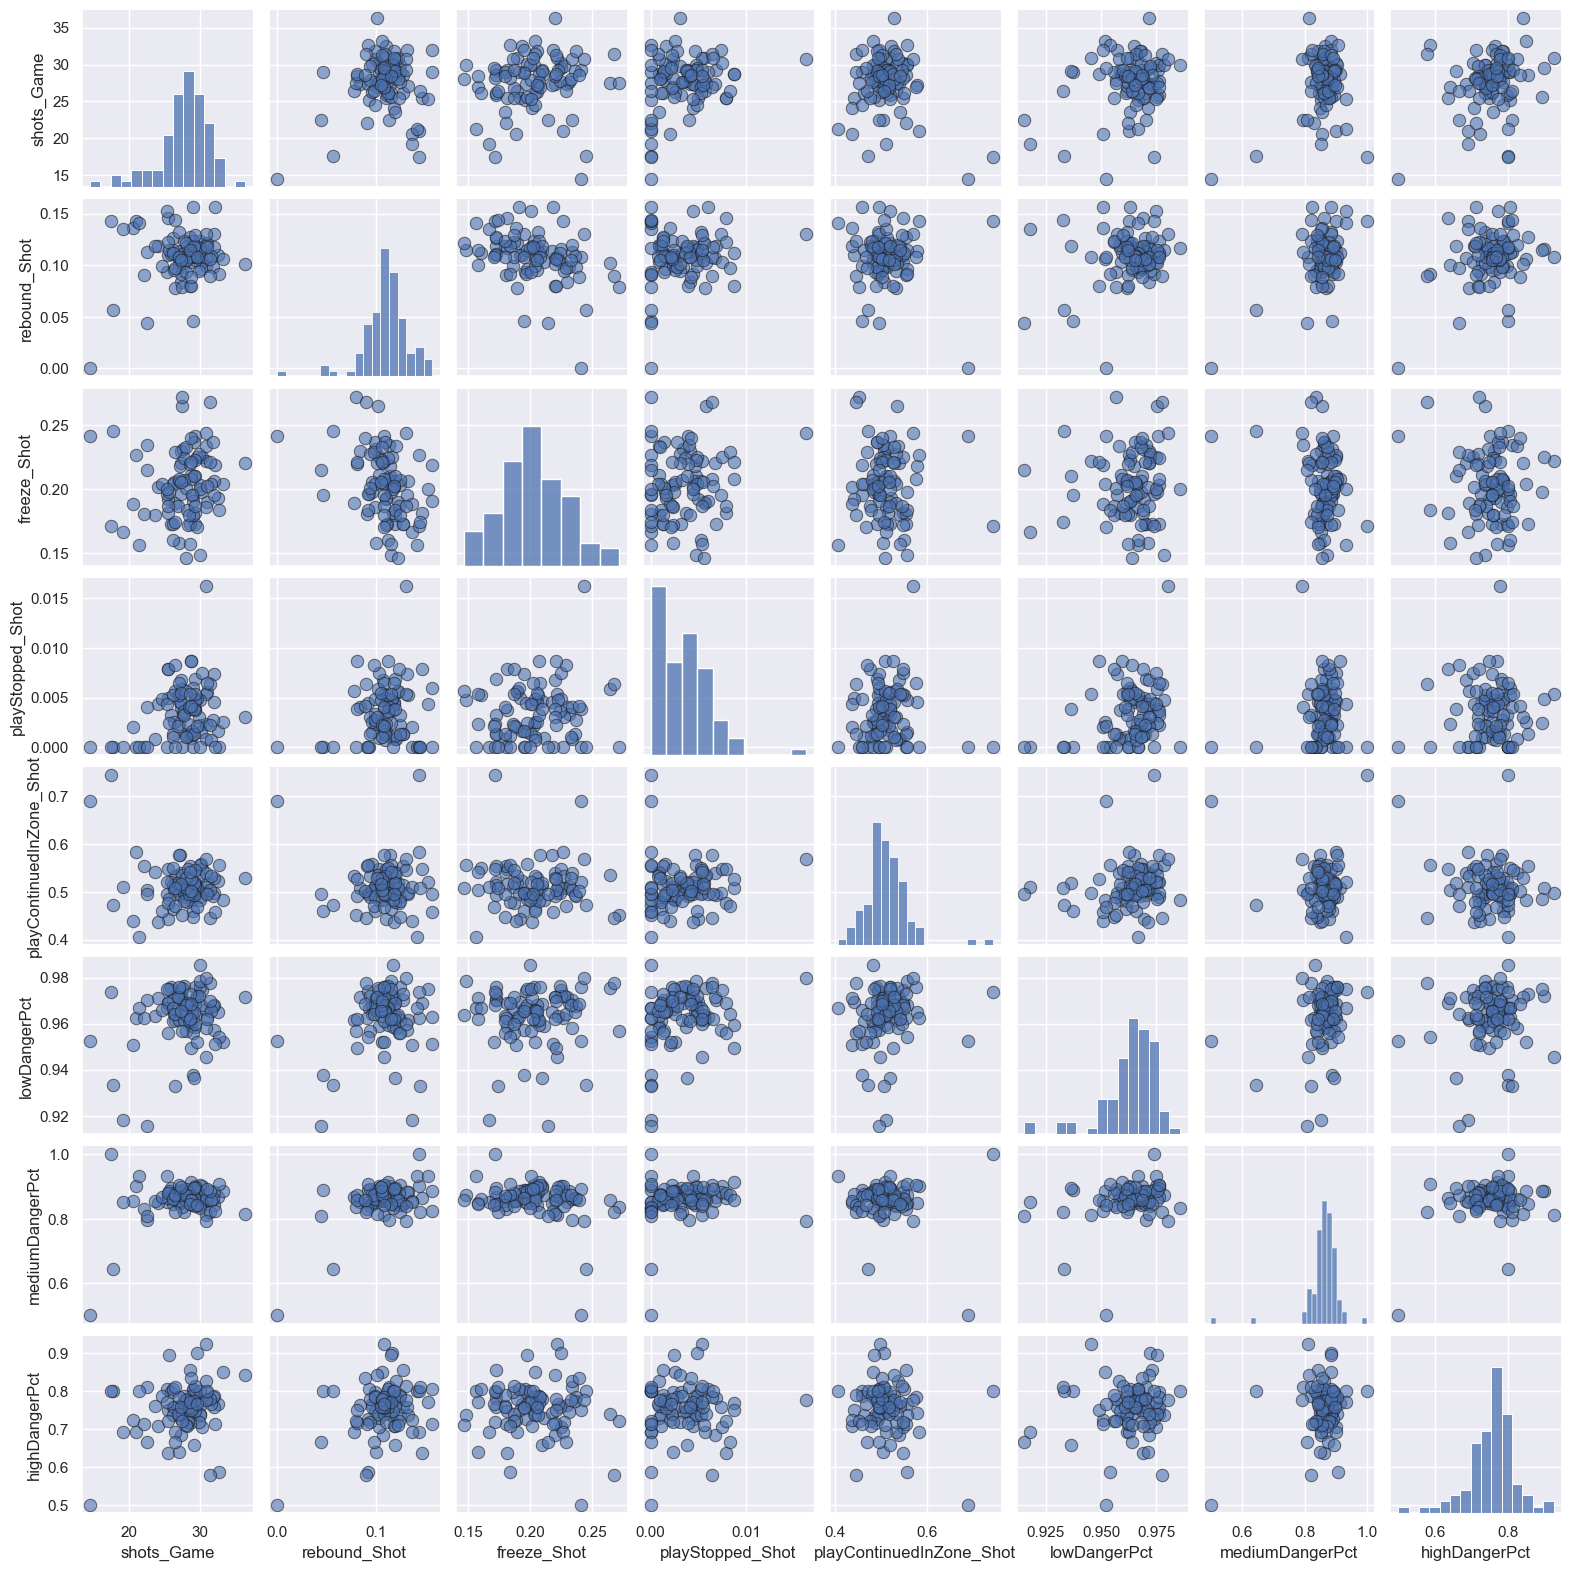

In [10]:
sns.pairplot(df_all, vars = numerical_columns, diag_kind = 'hist', plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, height = 2)

<Axes: >

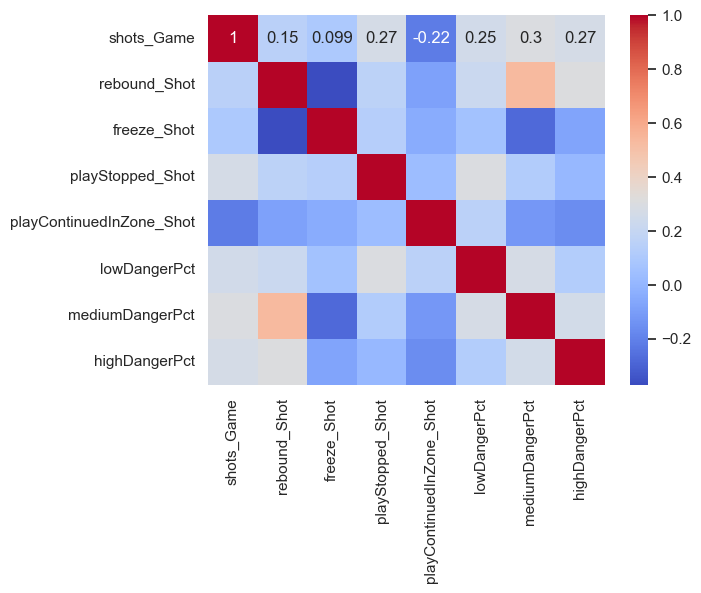

In [11]:
correlation_matrix = df_all[numerical_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

## Plotting with PCA

In [12]:
X_all = df_all[numerical_columns].to_numpy()
y_all = df_all['gsax_game'].to_numpy()

scaler = StandardScaler()
Xs_all = scaler.fit_transform(X_all)

pca = PCA(n_components=1)
Xp_all = pca.fit_transform(Xs_all)

In [49]:
df_all[numerical_columns]

,shots_Game,rebound_Shot,freeze_Shot,playStopped_Shot,playContinuedInZone_Shot,lowDangerPct,mediumDangerPct,highDangerPct
1,29.218182,0.118855,0.172371,0.006845,0.492222,0.970218,0.868354,0.781065
6,27.333333,0.083333,0.229675,0.004065,0.506775,0.971734,0.851582,0.763889
11,27.342105,0.106833,0.220404,0.006737,0.539942,0.971747,0.854093,0.685393
16,29.254902,0.113941,0.209786,0.004692,0.512064,0.968670,0.900285,0.779661
21,30.200000,0.102649,0.225166,0.007450,0.548013,0.974759,0.900000,0.705036
...,...,...,...,...,...,...,...,...
466,29.263158,0.129496,0.187050,0.005396,0.544964,0.959936,0.840000,0.813559
471,30.880000,0.117876,0.202073,0.006477,0.494819,0.961832,0.891509,0.802083
476,28.620000,0.088749,0.239693,0.004193,0.501747,0.968593,0.857527,0.834483
481,28.484848,0.114894,0.157447,0.005319,0.541489,0.962136,0.844538,0.771186


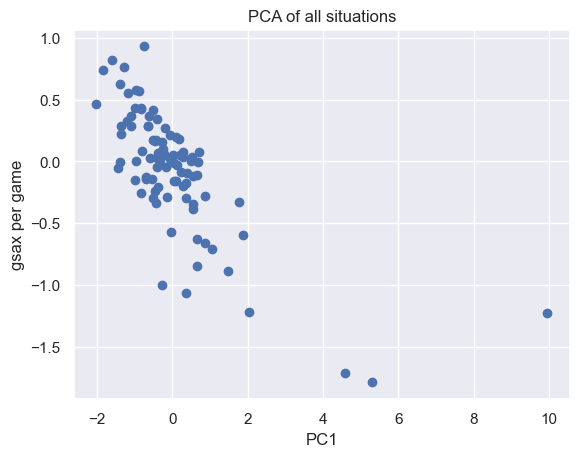

In [13]:
plt.scatter(Xp_all[:, :], y_all)
plt.xlabel('PC1')
plt.ylabel('gsax per game')
plt.title('PCA of all situations')
plt.show()

In [14]:
weights = pca.components_
print(weights)

[[-0.3750478  -0.49190694  0.19851471 -0.24476343  0.13526306 -0.33175474
  -0.51087321 -0.35874886]]


In [15]:
X_4on5 = df_4on5[numerical_columns].to_numpy()
y_4on5 = df_4on5['gsax_game'].to_numpy()

scaler = StandardScaler()
Xs_4on5 = scaler.fit_transform(X_4on5)

pca = PCA(n_components=1)
Xp_4on5 = pca.fit_transform(Xs_4on5)

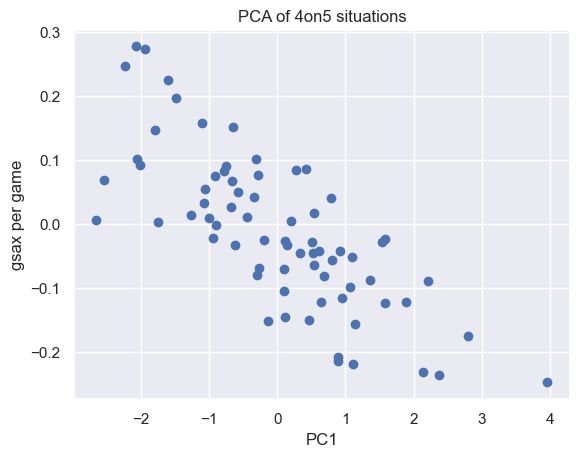

In [16]:
plt.scatter(Xp_4on5[:, :], y_4on5)
plt.xlabel('PC1')
plt.ylabel('gsax per game')
plt.title('PCA of 4on5 situations')
plt.show()

In [17]:
weights = pca.components_
print(weights)

[[-0.16891884 -0.41873512  0.09993317 -0.30281144 -0.4674083  -0.38502509
  -0.28874169 -0.49432713]]


- Testing
    - Explain which models to pick and why
    - Test all the models and pick the best one and plot the results.
    - Test the best model on another split with confusion matrix and plot of prediction, and boundary plot
    

In [18]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

## Linear Regression

In [19]:
X_all = df_all[numerical_columns].to_numpy()
y_all = df_all['gsax_game'].to_numpy()

XScaler = StandardScaler()
YScaler = StandardScaler()

Xs_all = XScaler.fit_transform(X_all)
ys_all = YScaler.fit_transform(y_all.reshape(-1, 1))



In [20]:
linear = LinearRegression()
scores = cross_val_score(linear, Xs_all, ys_all, cv=cv, scoring='r2')
print(f'Linear Regression R^2: {scores.mean()}')

Linear Regression R^2: 0.7043751047040008


## Quadratic Regression

In [21]:
poly = PolynomialFeatures(degree=2, include_bias=False)
Xs2_all = poly.fit_transform(Xs_all)

In [22]:
quad = LinearRegression()

scores = cross_val_score(quad, Xs2_all, ys_all, cv=cv, scoring='r2')

print(f'Quadratic Regression R^2: {scores.mean()}')

Quadratic Regression R^2: 0.5995642466623095


In [23]:
#fitting the data and testing once to confirm cross-validation r2 score
Xs2_train, Xs2_test, ys_train, ys_test = train_test_split(Xs2_all, ys_all, test_size=0.2, shuffle = True, random_state=42)

quad.fit(Xs2_train, ys_train)

ys_pred = quad.predict(Xs2_test)
ys_pred_train = quad.predict(Xs2_train)

r2_test = r2_score(ys_test, ys_pred)
r2_train = r2_score(ys_train, ys_pred_train)

print(f'Quadratic Regression R^2 (train): {r2_train}')
print(f'Quadratic Regression R^2 (test): {r2_test}')

Quadratic Regression R^2 (train): 0.9952325681607267
Quadratic Regression R^2 (test): 0.6888038425937831


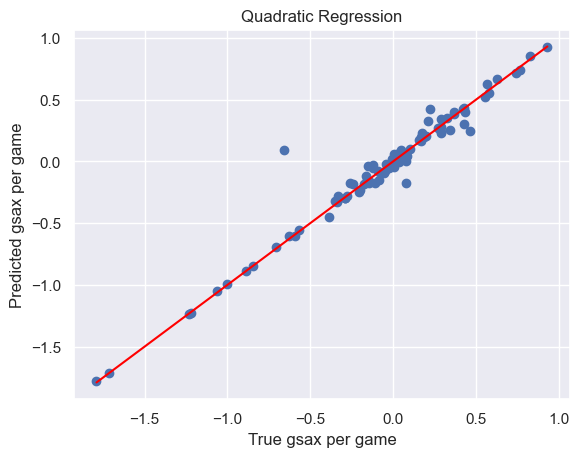

In [24]:
#plotting the predictions vs true values

all_predictions = quad.predict(Xs2_all)
all_predictions = YScaler.inverse_transform(all_predictions)
y_all = YScaler.inverse_transform(ys_all)

plt.scatter(y_all, all_predictions)
plt.plot([min(y_all), max(y_all)], [min(y_all), max(y_all)], color='red')
plt.xlabel('True gsax per game')
plt.ylabel('Predicted gsax per game')
plt.title('Quadratic Regression')
plt.show()

## Lasso

Text(0.5, 1.0, 'Lasso Regression')

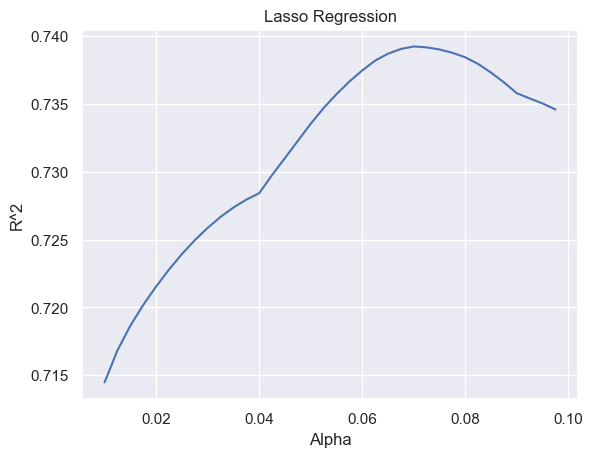

In [25]:
#finding the best alpha
alphas = np.arange(0.01, 0.1, 0.0025)
scores = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    scores.append(cross_val_score(lasso, Xs_all, ys_all, cv=cv, scoring='r2').mean())

plt.plot(alphas, scores)
plt.xlabel('Alpha')
plt.ylabel('R^2')
plt.title('Lasso Regression')

In [26]:
#cross-validating the best lasso model
lasso = Lasso(alpha=0.085)
scores = cross_val_score(lasso, Xs_all, ys_all, cv=cv, scoring='r2')
print(f'Lasso Regression R^2: {scores.mean()}')

Lasso Regression R^2: 0.7373057689607853


## Decision Tree

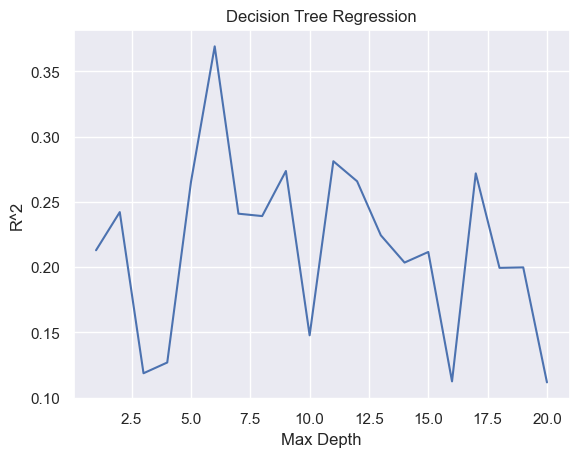

In [27]:
#finding the best max_depth for a decision tree model
max_depths = list(range(1, 21))
scores = []
for max_depth in max_depths:
    tree = DecisionTreeRegressor(max_depth=max_depth, criterion='squared_error')
    scores.append(cross_val_score(tree, Xs_all, ys_all, cv=cv, scoring='r2').mean())

plt.plot(max_depths, scores)
plt.xlabel('Max Depth')
plt.ylabel('R^2')
plt.title('Decision Tree Regression')
plt.show()
#{'absolute_error', 'poisson', 'friedman_mse', 'squared_error'}

## AdaBoost

Text(0.5, 1.0, 'AdaBoost Regression')

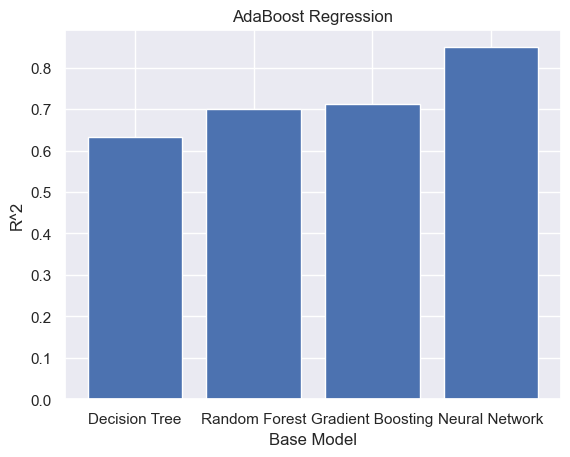

In [28]:
#determining the best base estimator for adaboost

base_models = [DecisionTreeRegressor(max_depth=3, criterion='squared_error'),
RandomForestRegressor(n_estimators=100, max_depth=3),
GradientBoostingRegressor(n_estimators=100, max_depth=3),
MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=1000),]

scores = []

for base_model in base_models:
    ada = AdaBoostRegressor(estimator=base_model, n_estimators=100)
    scores.append(cross_val_score(ada, Xs_all, ys_all.flatten(), cv=cv, scoring='r2').mean())

plt.bar(['Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network'], scores)
plt.xlabel('Base Model')
plt.ylabel('R^2')
plt.title('AdaBoost Regression')

In [29]:
#finding the best parameters outside of the base model

model = AdaBoostRegressor()

param_grid = {
    'n_estimators' : [50, 100, 150, 200],
    'learning_rate' : [0.01, 0.25, 0.5, 0.75]
}

ada_grid = GridSearchCV(model, param_grid, cv=cv, scoring='r2')

ada_grid.fit(Xs_all, ys_all.flatten())

print('### AdaBoost Performance ###')
print('Best parameters: ')
for param, value in ada_grid.best_params_.items():
    print(f'{param}: {value}')

print(f'Best R^2: {ada_grid.best_score_}')

### AdaBoost Performance ###
Best parameters: 
learning_rate: 0.75
n_estimators: 150
Best R^2: 0.6210008395369225


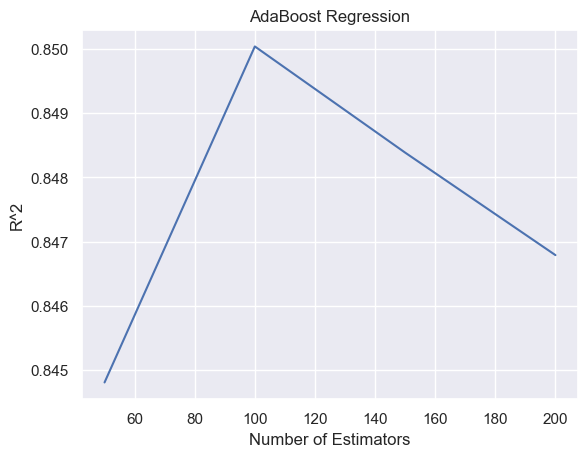

In [30]:
#testing the parameters with the base model
n_estimators = [50, 100, 150, 200]
scores = []
for number in n_estimators:
    ada = AdaBoostRegressor(estimator=MLPRegressor(hidden_layer_sizes = (100, 100), max_iter = 1000), n_estimators=number, learning_rate=0.75)
    score = cross_val_score(ada, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
    scores.append(score.mean())

plt.plot(n_estimators, scores)
plt.xlabel('Number of Estimators')
plt.ylabel('R^2')
plt.title('AdaBoost Regression')
plt.show()

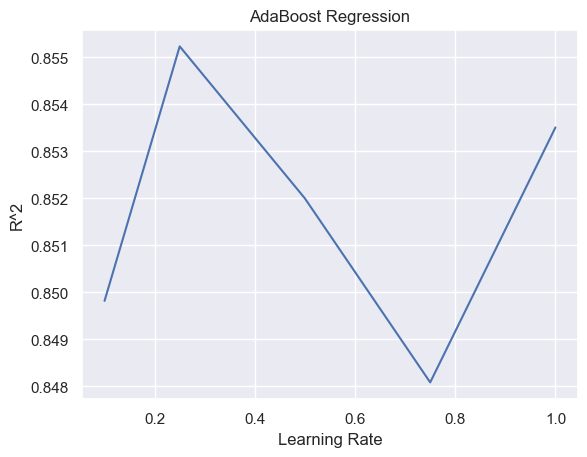

In [31]:
#finding the best learning rate for the adaboost model
lr = [0.1, 0.25, 0.5, 0.75, 1.0]
scores = []

for rate in lr:
    ada = AdaBoostRegressor(estimator=MLPRegressor(hidden_layer_sizes = (100, 100), max_iter = 1000), n_estimators=150, learning_rate=rate)
    score = cross_val_score(ada, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
    scores.append(score.mean())

plt.plot(lr, scores)
plt.xlabel('Learning Rate')
plt.ylabel('R^2')
plt.title('AdaBoost Regression')
plt.show()

In [53]:
#getting the r2 score of the best adaboost model

best_ada = AdaBoostRegressor(estimator=MLPRegressor(hidden_layer_sizes = (16, 32),
                                                     max_iter = 1000,
                                                     learning_rate_init=0.001,
                                                     batch_size = 15,
                                                     activation = 'logistic', #logistic is better for problems with negative y-values
                                                     random_state=42),
                            n_estimators=100,
                            learning_rate=0.25,
                            random_state=42)
scores = cross_val_score(best_ada, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
print(f'AdaBoost Regression R^2: {scores.mean()}')

AdaBoost Regression R^2: 0.9027167841374315


## Gradient Boosting

Gradient Boosting depth: 1
Gradient Boosting R^2: 0.7733482820337354


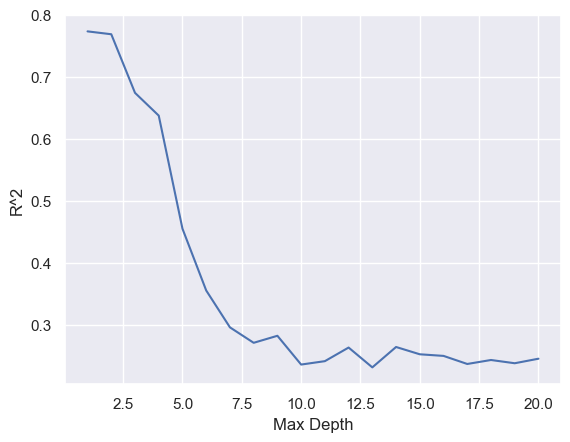

In [33]:
#finding the best parameters for the gradient boosting model
#finding the best max depth

max_depths = list(range(1, 21))
scores = []

for depth in max_depths:
    gb = GradientBoostingRegressor(max_depth=depth)
    score = cross_val_score(gb, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
    scores.append(score.mean())

plt.plot(max_depths, scores)
plt.xlabel('Max Depth')
plt.ylabel('R^2')

#printing the best r2 score and depth
print(f'Gradient Boosting depth: {max_depths[scores.index(max(scores))]}')
print(f'Gradient Boosting R^2: {max(scores)}')

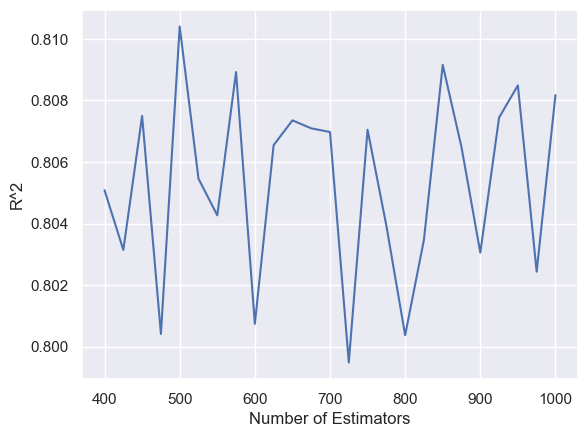

In [34]:
#finding the best number of estimators

estimators = [400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650, 675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975, 1000]
scores = []

for number in estimators:
    gb = GradientBoostingRegressor(max_depth=1, n_estimators=number)
    score = cross_val_score(gb, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
    scores.append(score.mean())

plt.plot(estimators, scores)
plt.xlabel('Number of Estimators')
plt.ylabel('R^2')
plt.show()

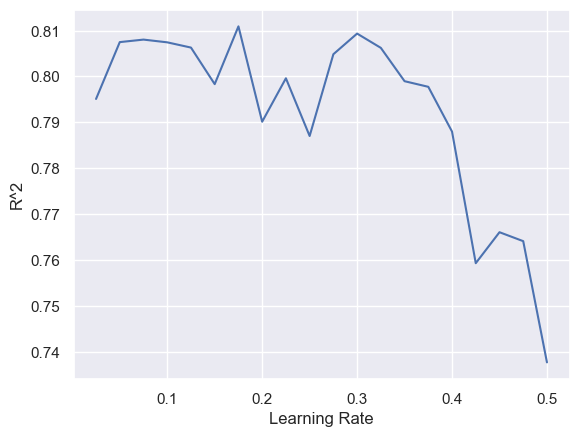

In [35]:
#finding the best learning rate for gradient boosting model
lr = [0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325, 0.35, 0.375, 0.4, 0.425, 0.45, 0.475, 0.5]
scores = []

for rate in lr:
    gb = GradientBoostingRegressor(max_depth=1, n_estimators=550, learning_rate=rate)
    score = cross_val_score(gb, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
    scores.append(score.mean())

plt.plot(lr, scores)
plt.xlabel('Learning Rate')
plt.ylabel('R^2')
plt.show()

In [36]:
#testing the best parameters for the gradient boosting model

best_gb = GradientBoostingRegressor(max_depth=1, n_estimators=550, learning_rate=0.075)
scores = cross_val_score(best_gb, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
print(f'Gradient Boosting R^2: {scores.mean()}')

Gradient Boosting R^2: 0.8119306131783214


## Random Forest

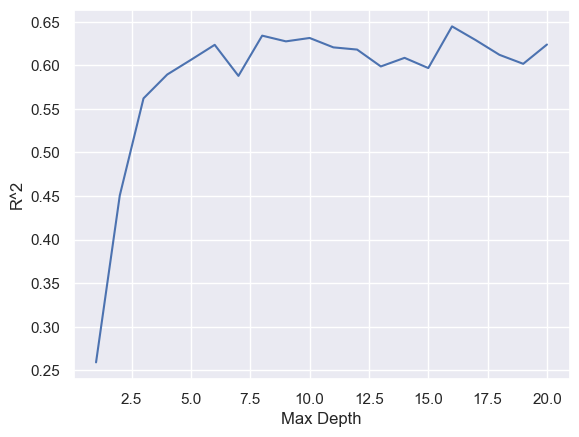

Random Forest depth: 16
Random Forest R^2: 0.6445167665648515


In [37]:
#finding the best max_depth

max_depths = list(range(1, 21))
scores = []

for depth in max_depths:
    rf = RandomForestRegressor(max_depth=depth)
    score = cross_val_score(rf, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
    scores.append(score.mean())

plt.plot(max_depths, scores)
plt.xlabel('Max Depth')
plt.ylabel('R^2')
plt.show()

#printing the best r2 and max depth
print(f'Random Forest depth: {max_depths[scores.index(max(scores))]}')
print(f'Random Forest R^2: {max(scores)}')

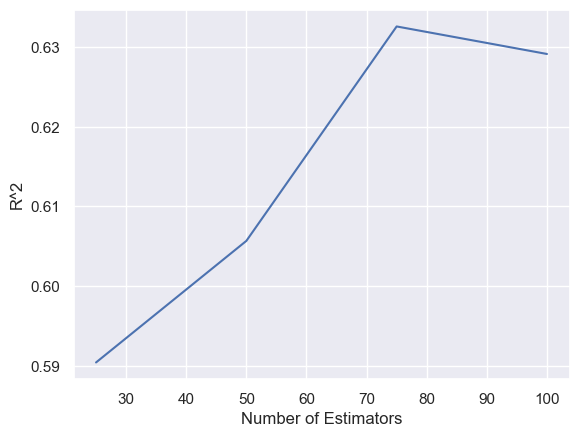

In [38]:
#finding the best parameters for random forest
#finding the best number of estimators

estimators = [25, 50, 75, 100]
scores = []

for number in estimators:
    rf = RandomForestRegressor(n_estimators=number, max_depth=6)
    score = cross_val_score(rf, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
    scores.append(score.mean())

plt.plot(estimators, scores)
plt.xlabel('Number of Estimators')
plt.ylabel('R^2')
plt.show()

## MLP

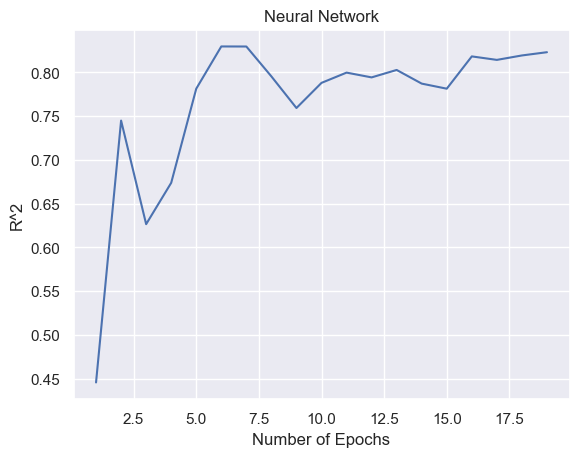

In [39]:
model = MLPRegressor(
    hidden_layer_sizes=(16, 32),
    max_iter=1000,
    batch_size= 10,
    learning_rate= 'constant',
    learning_rate_init= 0.01
)

Xs_all_train, Xs_all_test, ys_all_train, ys_all_test = train_test_split(Xs_all, ys_all, test_size=0.2, shuffle=True, random_state=42)

num_epochs = range(1, 20)
scores = []
for epoch in num_epochs:
    model.partial_fit(Xs_all_train, ys_all_train.flatten())
    score = model.score(Xs_all_test, ys_all_test.flatten())
    scores.append(score)

plt.plot(num_epochs, scores)
plt.xlabel('Number of Epochs')
plt.ylabel('R^2')
plt.title('Neural Network')
plt.show()



In [46]:
#performing a grid search for the best parameters for the neural network
mlp = MLPRegressor(random_state=42)

param_grid = {
    'hidden_layer_sizes' : [(16, 32), (32, 64), (64, 128), (16, 32, 64)],
    'max_iter' : [1000, 2500, 5000, 10000],
    'batch_size' : [5, 10, 15],
    'learning_rate_init' : [0.001, 0.01],
    'activation' : ['logistic', 'tanh', 'relu']
}

mlp_grid = GridSearchCV(mlp, param_grid, cv=cv, scoring='r2')

mlp_grid.fit(Xs_all, ys_all.flatten())

print('### Neural Network Performance ###')
print('Best parameters: ')
for param, value in mlp_grid.best_params_.items():
    print(f'{param}: {value}')

scores = cross_val_score(mlp_grid.best_estimator_, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
print(f'Best R^2: {scores.mean()}')

### Neural Network Performance ###
Best parameters: 
activation: logistic
batch_size: 15
hidden_layer_sizes: (16, 32)
learning_rate_init: 0.001
max_iter: 1000
Best R^2: 0.906797142716188


In [52]:
mlp = MLPRegressor(
    hidden_layer_sizes=(16, 32),
    max_iter=1000,
    batch_size= 15,
    learning_rate= 'constant',
    learning_rate_init= 0.001,
    activation = 'logistic',
    random_state=42
)

scores = cross_val_score(mlp, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
print(f'Neural Network R^2: {scores.mean()}')

Neural Network R^2: 0.906797142716188


## **Best Model**

In [54]:
best_model = MLPRegressor(
    hidden_layer_sizes=(16, 32),
    max_iter=1000,
    batch_size= 15,
    learning_rate= 'constant',
    learning_rate_init= 0.001,
    activation = 'logistic',
    random_state=42
)

scores = cross_val_score(mlp, Xs_all, ys_all.flatten(), cv=cv, scoring='r2')
print(f'Neural Network R^2: {scores.mean()}')

Neural Network R^2: 0.906797142716188


## Prediction

In [60]:
df_all_names = df_full.loc[df_full['situation'] == 'all', numerical_columns + ['gsax_game'] + ['name']]
skinner = df_all_names.loc[df_all_names['name'] == 'Stuart Skinner']

X_skinner = skinner[numerical_columns].to_numpy()
y_skinner = skinner['gsax_game'].to_numpy()

Scaler1 = StandardScaler()
Scaler2 = StandardScaler()

Xs_skinner = Scaler1.fit_transform(X_skinner)
ys_skinner = Scaler2.fit_transform(y_skinner.reshape(-1, 1))

In [64]:
best_model.fit(Xs_all, ys_all.flatten())
prediction = best_model.predict(Xs_skinner)
Scaler2.inverse_transform(prediction.reshape(-1, 1))

array([[0.01573771]])

-  Features
    - which features is important
    - explain why

- Prediction 
    - Train on the whole set with the best model
    - predict values you pick.

- More
    - Try an ensemble model with average
    - Try an ensemble model with regression